# Lead Scoring Case Study

#### Problem Statement
An X Education need help to select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires us to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

#### Goals of Case Study

Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.

In [449]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [450]:
#importing libraries

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
pd.set_option('display.max_columns',False)

# Reading and Understanding Data

## Importing and Inspecting Data

In [451]:
leads_df=pd.read_csv('Leads.csv') # Reading leads dataframe as lead_df
leads_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [452]:
#shape of the dataframe
leads_df.shape

(9240, 37)

In [453]:
#Statstical aspects of the dataframe
leads_df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [454]:
#inspecting info of each columns 
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

We can see there are few categorical values for which we have to create dummy variables. Also, we have to take care of the null- values.

In [455]:
#check for duplicates
sum(leads_df.duplicated(subset = 'Prospect ID')) == 0

True

In [456]:
#check for duplicates
sum(leads_df.duplicated(subset = 'Lead Number')) == 0

True

*No duplicate values exist in 'Prospect ID' and 'Lead Number'*

# Exploratory Data Analysis

## Data Cleaning

In [457]:
#dropping Lead Number and Prospect ID since they have all unique values

leads_df.drop(['Prospect ID', 'Lead Number'], 1, inplace = True)

In [458]:
#Converting 'Select' values to NaN.
#As can be seen,there are few columns with level called 'Select' which means that the customer had not selected the option for that particular column which is why it shows 'Select'. These values are as good as missing values and hence we will convert 'Select' values to Nan

leads_df = leads_df.replace('Select', np.nan)

In [459]:
#Checking for count of missing values in each column
leads_df.isnull().sum()

Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

In [460]:
#checking percentage of null values in each column

round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

 ## Dropping Columns with Missing Values >=40%

In [461]:
#Drop all the columns with more than 40% missing values
cols=leads_df.columns

for i in cols:
    if((100*(leads_df[i].isnull().sum()/len(leads_df.index))) >= 40):
        leads_df.drop(i, 1, inplace = True)

In [462]:
#checking percentage of null values in each column after dropping >=35% of missing vales

round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

## Univariate Analysis

## Visualising Numeric Variables

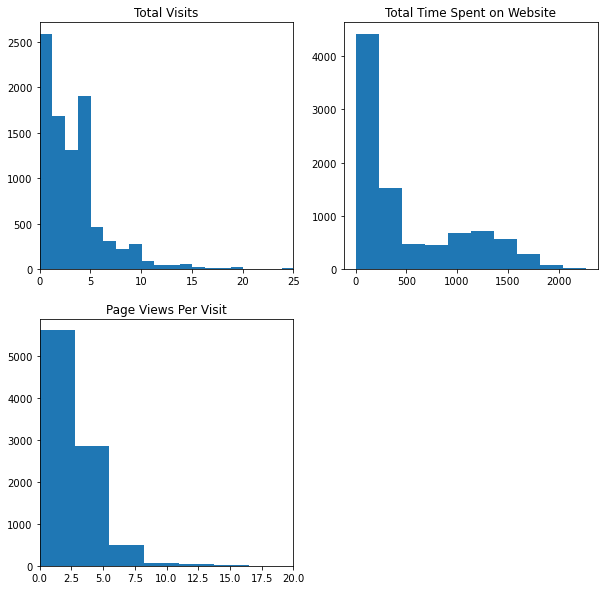

In [463]:
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.hist(leads_df['TotalVisits'], bins = 200)
plt.title('Total Visits')
plt.xlim(0,25)

plt.subplot(222)
plt.hist(leads_df['Total Time Spent on Website'], bins = 10)
plt.title('Total Time Spent on Website')

plt.subplot(223)
plt.hist(leads_df['Page Views Per Visit'], bins = 20)
plt.title('Page Views Per Visit')
plt.xlim(0,20)
plt.show()

## Visualising Categorical Variables

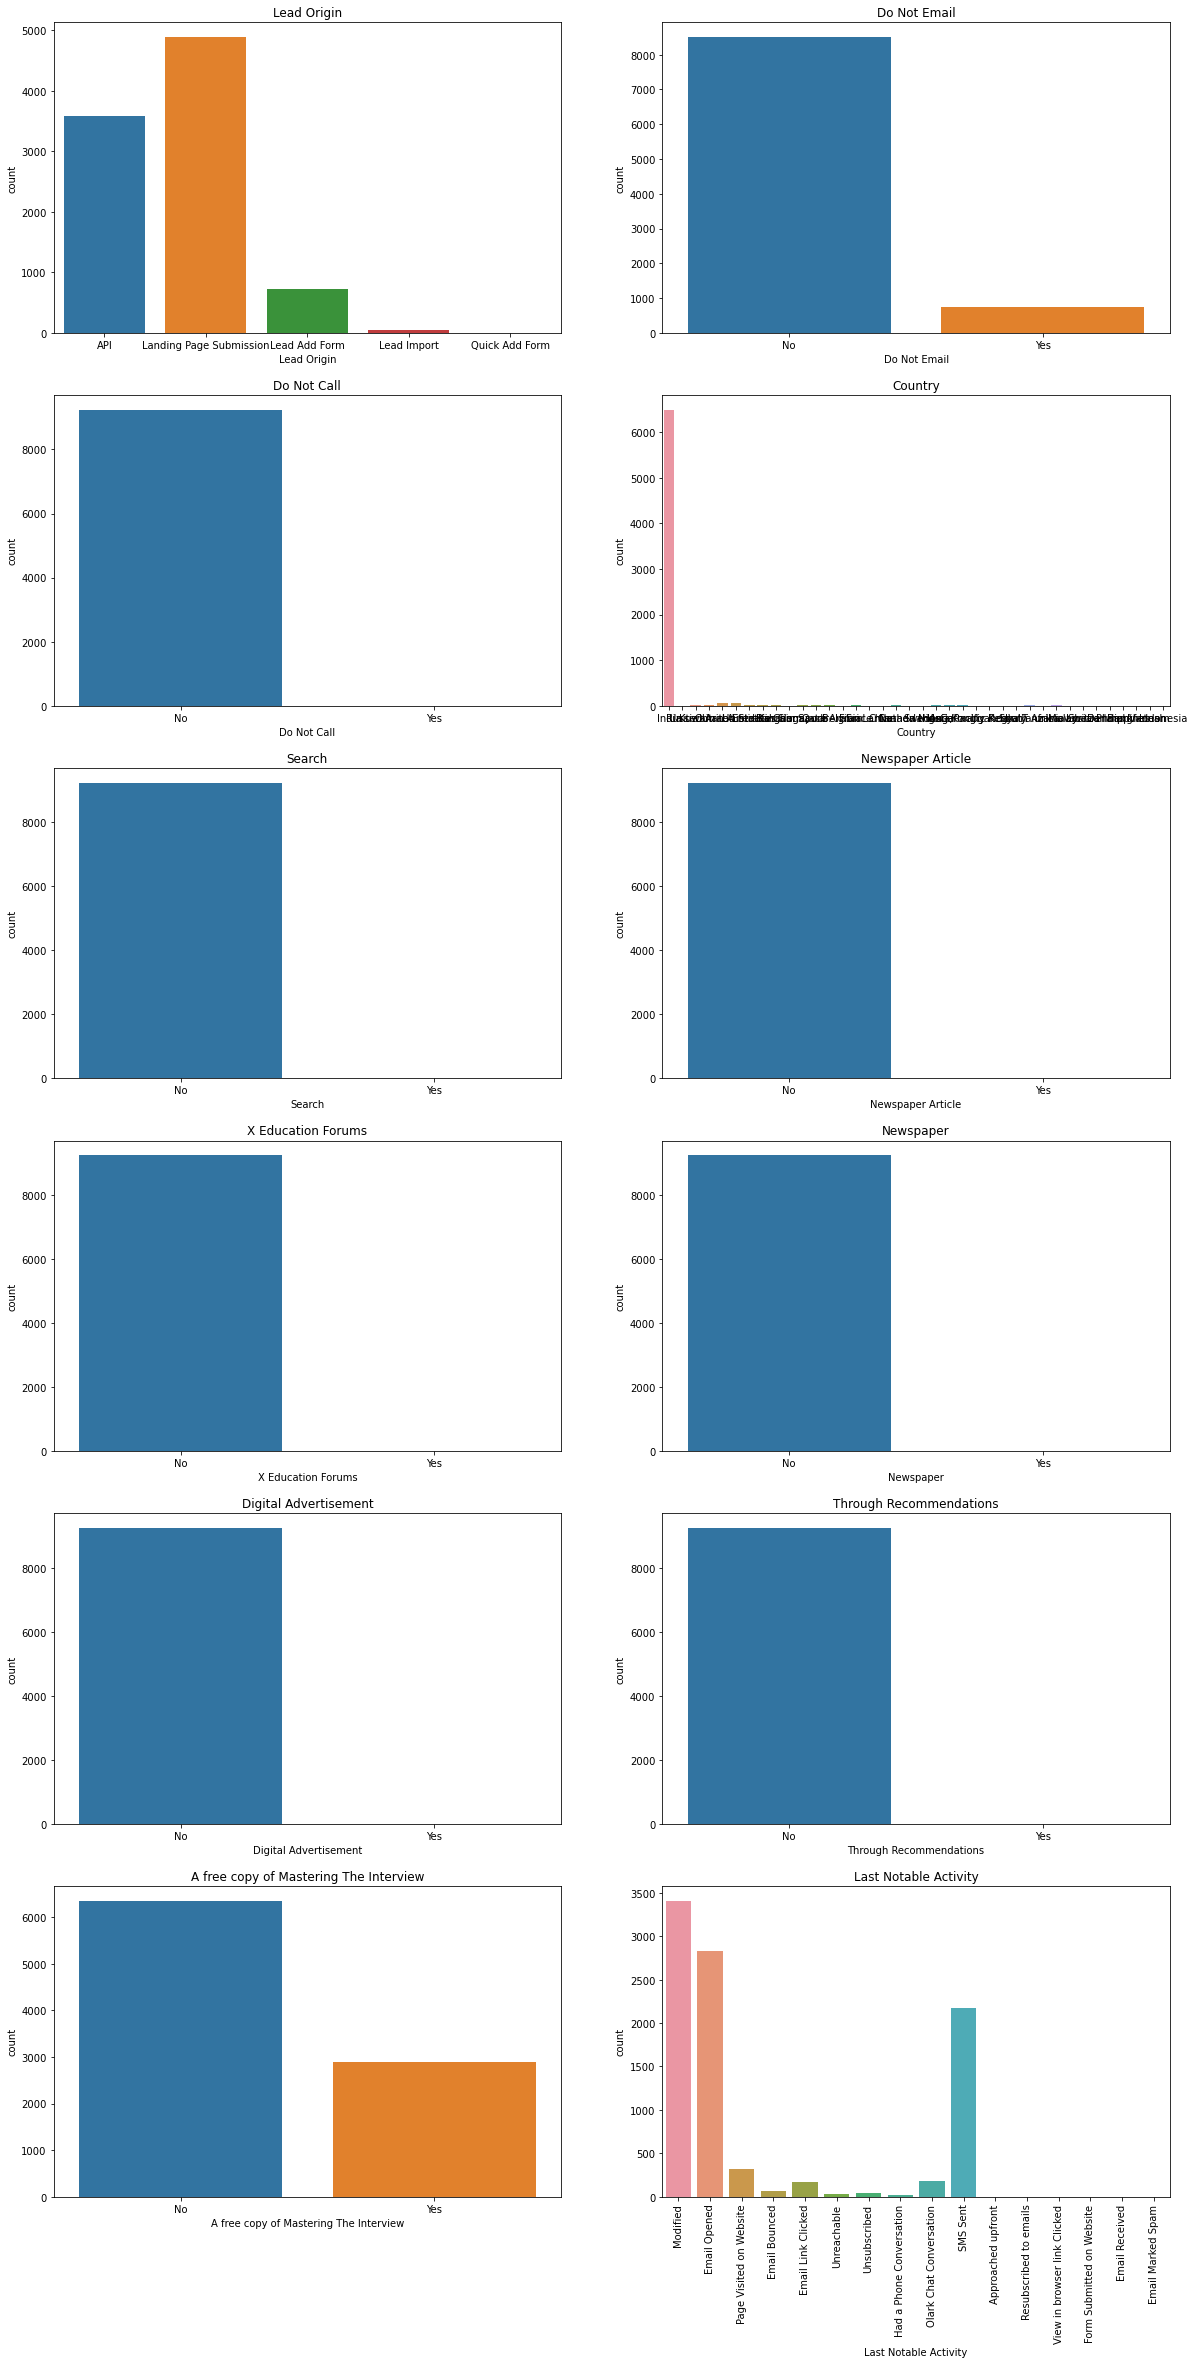

In [464]:
plt.figure(figsize = (20,40))

plt.subplot(6,2,1)
sns.countplot(leads_df['Lead Origin'])
plt.title('Lead Origin')

plt.subplot(6,2,2)
sns.countplot(leads_df['Do Not Email'])
plt.title('Do Not Email')

plt.subplot(6,2,3)
sns.countplot(leads_df['Do Not Call'])
plt.title('Do Not Call')

plt.subplot(6,2,4)
sns.countplot(leads_df['Country'])
plt.title('Country')

plt.subplot(6,2,5)
sns.countplot(leads_df['Search'])
plt.title('Search')

plt.subplot(6,2,6)
sns.countplot(leads_df['Newspaper Article'])
plt.title('Newspaper Article')

plt.subplot(6,2,7)
sns.countplot(leads_df['X Education Forums'])
plt.title('X Education Forums')

plt.subplot(6,2,8)
sns.countplot(leads_df['Newspaper'])
plt.title('Newspaper')

plt.subplot(6,2,9)
sns.countplot(leads_df['Digital Advertisement'])
plt.title('Digital Advertisement')

plt.subplot(6,2,10)
sns.countplot(leads_df['Through Recommendations'])
plt.title('Through Recommendations')

plt.subplot(6,2,11)
sns.countplot(leads_df['A free copy of Mastering The Interview'])
plt.title('A free copy of Mastering The Interview')

plt.subplot(6,2,12)
sns.countplot(leads_df['Last Notable Activity']).tick_params(axis='x', rotation = 90)
plt.title('Last Notable Activity')


plt.show()


##  Visualizing  variables for any imbalnce and droping the colums which have high imabalance

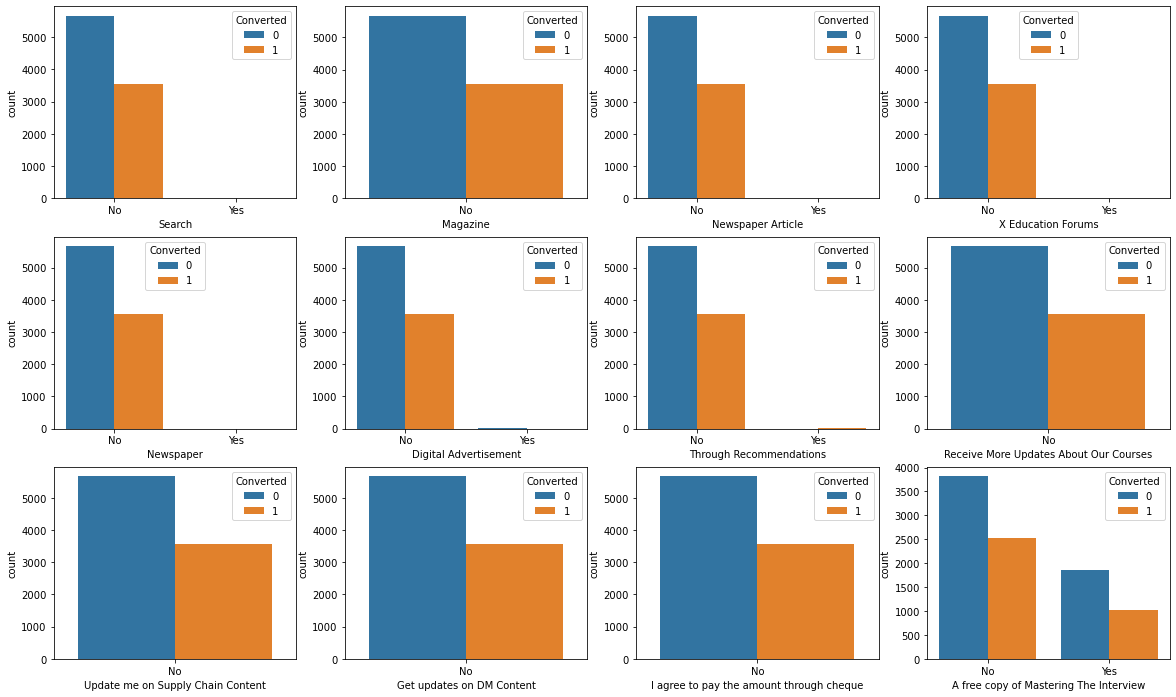

In [465]:

fig, axs = plt.subplots(3,4,figsize = (20,12))
sns.countplot(x = "Search", hue = "Converted", data = leads_df, ax = axs[0,0])
sns.countplot(x = "Magazine", hue = "Converted", data = leads_df, ax = axs[0,1])
sns.countplot(x = "Newspaper Article", hue = "Converted", data = leads_df, ax = axs[0,2])
sns.countplot(x = "X Education Forums", hue = "Converted", data = leads_df, ax = axs[0,3])
sns.countplot(x = "Newspaper", hue = "Converted", data = leads_df, ax = axs[1,0])
sns.countplot(x = "Digital Advertisement", hue = "Converted", data = leads_df, ax = axs[1,1])
sns.countplot(x = "Through Recommendations", hue = "Converted", data = leads_df, ax = axs[1,2])
sns.countplot(x = "Receive More Updates About Our Courses", hue = "Converted", data = leads_df, ax = axs[1,3])
sns.countplot(x = "Update me on Supply Chain Content", hue = "Converted", data =leads_df, ax = axs[2,0])
sns.countplot(x = "Get updates on DM Content", hue = "Converted", data = leads_df, ax = axs[2,1])
sns.countplot(x = "I agree to pay the amount through cheque", hue = "Converted", data = leads_df, ax = axs[2,2])
sns.countplot(x = "A free copy of Mastering The Interview", hue = "Converted", data = leads_df, ax = axs[2,3])
plt.show()

In [466]:
#creating a list of columns to be dropped

col_drop=(['Search','Magazine','Newspaper Article','X Education Forums','Newspaper',
                 'Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses',
                 'Update me on Supply Chain Content',
                 'Get updates on DM Content','I agree to pay the amount through cheque'])

## Categorical Attributes Analysis:

#### Lead Source

In [467]:
#checking value counts of Lead Source column

leads_df['Lead Source'].value_counts(dropna=False)

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

Google has the highest number of occurences, hence we will impute the missing values with label 'Google'

In [468]:
#replacing Nan Values

leads_df['Lead Source'] = leads_df['Lead Source'].replace(np.nan,'Google')

## Replace 'google' with 'Google' as both serves the same purpose

leads_df['Lead Source'] = leads_df['Lead Source'].replace('google','Google')

## Combining Socail and Facebook as both serves the same purpose

leads_df['Lead Source'] = leads_df['Lead Source'].replace('Facebook','Social Media')



In [469]:
leads_df['Lead Source'].value_counts(dropna=False)

Google               2909
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Social Media           57
bing                    6
Click2call              4
Press_Release           2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

In [470]:
#combining low frequency values to Others

leads_df['Lead Source'] = leads_df['Lead Source'].replace(['bing','Click2call','Press_Release',
                                                     'youtubechannel','welearnblog_Home',
                                                     'WeLearn','blog','Pay per Click Ads',
                                                    'testone','NC_EDM','Live Chat'] ,'Others')

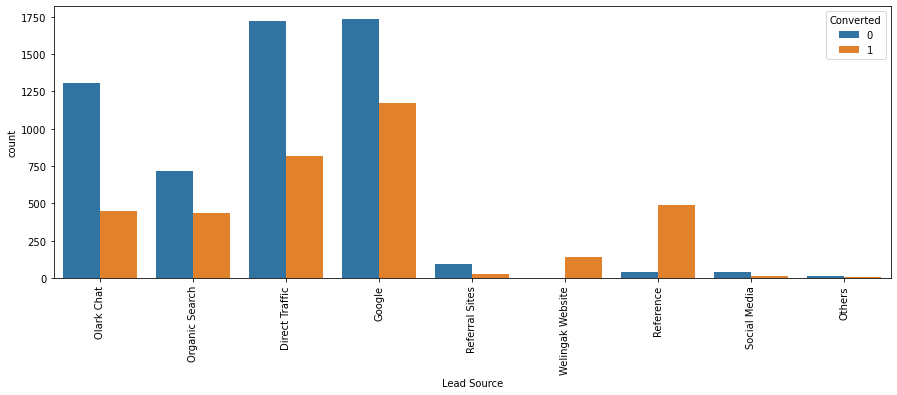

In [379]:
#visualizing count of Lead Source Variable based on Converted value
plt.figure(figsize=(15,5))
s1=sns.countplot(x= 'Lead Source', hue='Converted' , data =leads_df)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

Maximum Leads are generated by Google and Direct Traffic.

Conversion rate of Reference leads and Welinkgak Website leads is very high.

#### Country

In [380]:
#checking value counts of Country column

leads_df['Country'].value_counts(dropna=False)

India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switzerland   

In [381]:
leads_df['Country'] = leads_df['Country'].replace(np.nan,'India')

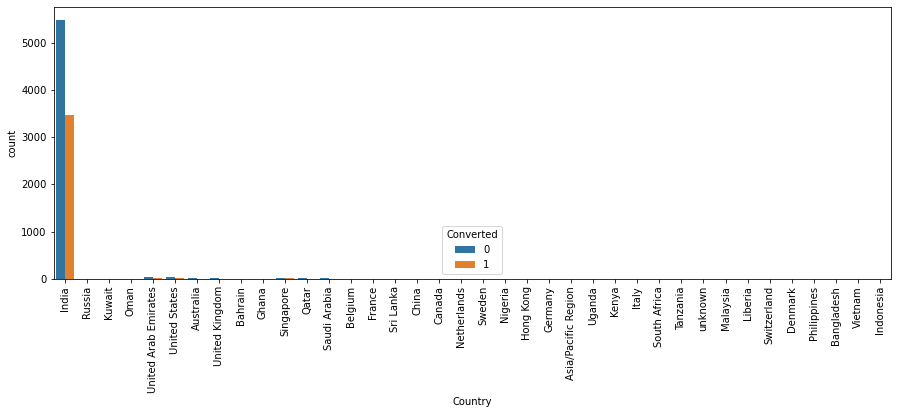

In [382]:
#plotting spread of Country columnn after replacing NaN values

plt.figure(figsize=(15,5))
s1=sns.countplot(leads_df.Country, hue=leads_df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

As we can see the Number of Values for India are quite high (nearly 97% of the Data), this column can be dropped

In [383]:
#Adding "Country" to the col_drop list

col_drop.append('Country')

#checking out list of columns to be dropped
col_drop

['Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque',
 'Country']

#### Tags

In [384]:
#checking value counts of Tag variable
leads_df['Tags'].value_counts(dropna=False)

NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with 

In [385]:
#replacing Nan values with "Not Specified"
leads_df['Tags'] = leads_df['Tags'].replace(np.nan,'Not Specified')

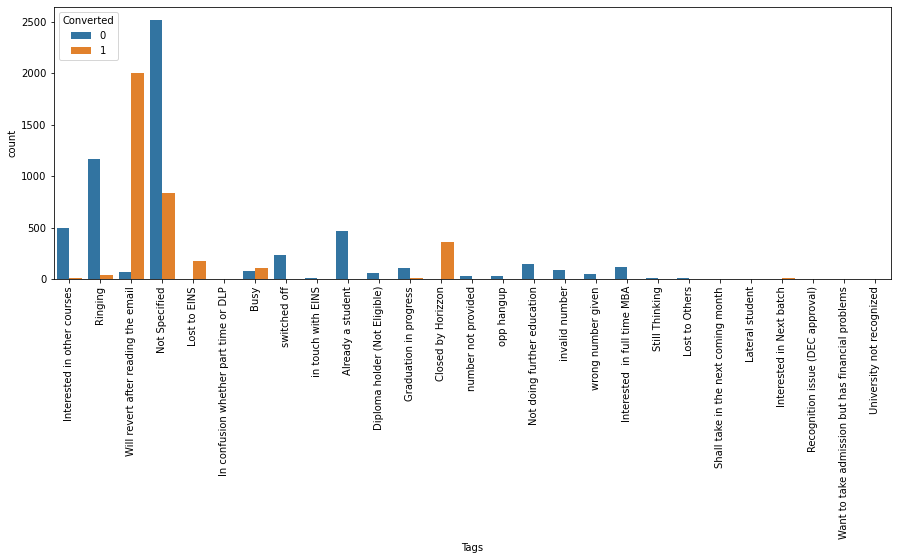

In [386]:
#visualizing count of Variable based on Converted value

plt.figure(figsize=(15,5))
s1=sns.countplot(leads_df['Tags'], hue=leads_df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [387]:
#replacing tags with low frequency with "Other Tags"
leads_df['Tags'] = leads_df['Tags'].replace(['In confusion whether part time or DLP', 'in touch with EINS','Diploma holder (Not Eligible)',
                                     'Approached upfront','Graduation in progress','number not provided', 'opp hangup','Still Thinking',
                                    'Lost to Others','Shall take in the next coming month','Lateral student','Interested in Next batch',
                                    'Recognition issue (DEC approval)','Want to take admission but has financial problems',
                                    'University not recognized'], 'Other_Tags')

leads_df['Tags'] = leads_df['Tags'].replace(['switched off',
                                      'Already a student',
                                       'Not doing further education',
                                       'invalid number',                'wrong number given',
                                       'Interested  in full time MBA'] , 'Other_Tags')

#### Specialization

In [388]:
#checking value counts of Specialization column

leads_df['Specialization'].value_counts(dropna=False)

NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

In [389]:
# Lead may not have mentioned specialization because it was not in the list or maybe they are a students 
# and don't have a specialization yet. So we will replace NaN values here with 'Not Specified'

leads_df['Specialization'] = leads_df['Specialization'].replace(np.nan, 'Not Specified')

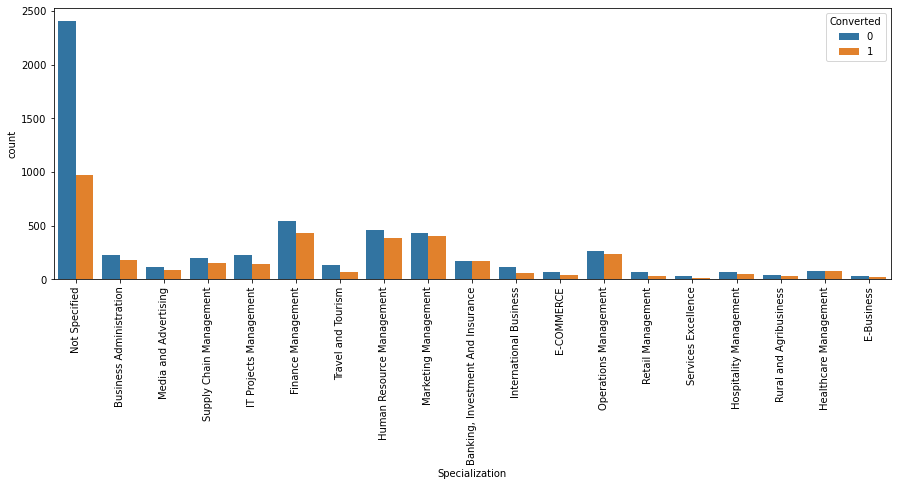

In [390]:
#plotting spread of Specialization columnn 

plt.figure(figsize=(15,5))
s1=sns.countplot(leads_df.Specialization, hue=leads_df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [391]:
#checking value counts of "City" column

leads_df['City'].value_counts(dropna=False)

NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

In [392]:
leads_df['City'] = leads_df['City'].replace(np.nan,'Mumbai')

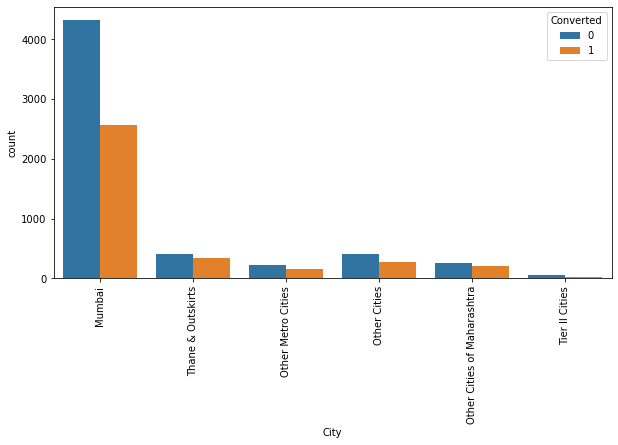

In [393]:
#plotting spread of City columnn after replacing NaN values

plt.figure(figsize=(10,5))
s1=sns.countplot(leads_df.City, hue=leads_df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

#### What is your current occupation

In [394]:
#checking value counts of 'What is your current occupation' column
leads_df['What is your current occupation'].value_counts(dropna=False)

Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [395]:
#Since no information has been provided regarding occupation, we can replace missing values with new category 'Unemployed'

leads_df['What is your current occupation'] = leads_df['What is your current occupation'].replace(np.nan, 'Unemployed ')

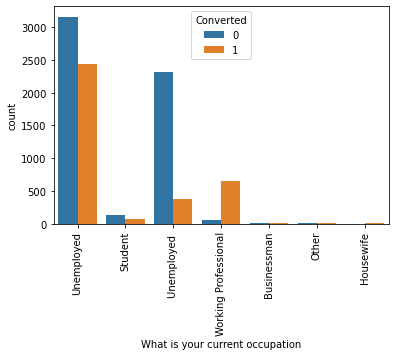

In [396]:
#visualizing count of Variable based on Converted value

s1=sns.countplot(leads_df['What is your current occupation'], hue=leads_df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

Working Professionals going for the course have high chances of joining it.

Unemployed leads are the most in terms of Absolute numbers.

#### What matters most to you in choosing a course

In [397]:
#checking value counts of 'What matters most to you in choosing a course'

leads_df['What matters most to you in choosing a course'].value_counts(dropna=False)

Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [398]:
#replacing Nan values with Mode "Better Career Prospects"

leads_df['What matters most to you in choosing a course'] = leads_df['What matters most to you in choosing a course'].replace(np.nan,'Better Career Prospects')

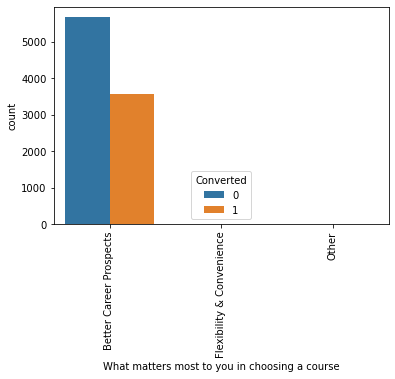

In [399]:
#visualizing count of Variable based on Converted value

s1=sns.countplot(leads_df['What matters most to you in choosing a course'], hue=leads_df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [400]:
#This column spread of variance is very low , hence it can be dropped.

# Append 'What matters most to you in choosing a course'to the cols_to_drop List
col_drop.append('What matters most to you in choosing a course')

col_drop

['Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque',
 'Country',
 'What matters most to you in choosing a course']

In [401]:
#checking percentage of null values in each column after first analysis

round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)

Lead Origin                                      0.00
Lead Source                                      0.00
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    1.11
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums                               0.00
Newspaper                                        0.00
Digital Advertisement       

#### Last Activity

In [402]:
#checking value counts of Last Activity
leads_df['Last Activity'].value_counts(dropna=False)

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: Last Activity, dtype: int64

In [403]:
 #replacing Nan Values with mode value "Email Opened"

leads_df['Last Activity'] = leads_df['Last Activity'].replace(np.nan,'Email Opened')

In [404]:
#combining low frequency values
leads_df['Last Activity'] = leads_df['Last Activity'].replace(['Unreachable','Unsubscribed',
                                                       'Had a Phone Conversation', 
                                                       'Approached upfront',
                                                        'View in browser link Clicked',       
                                                        'Email Marked Spam',                  
                                                        'Email Received','Resubscribed to emails',
                                                         'Visited Booth in Tradeshow'],'Others')

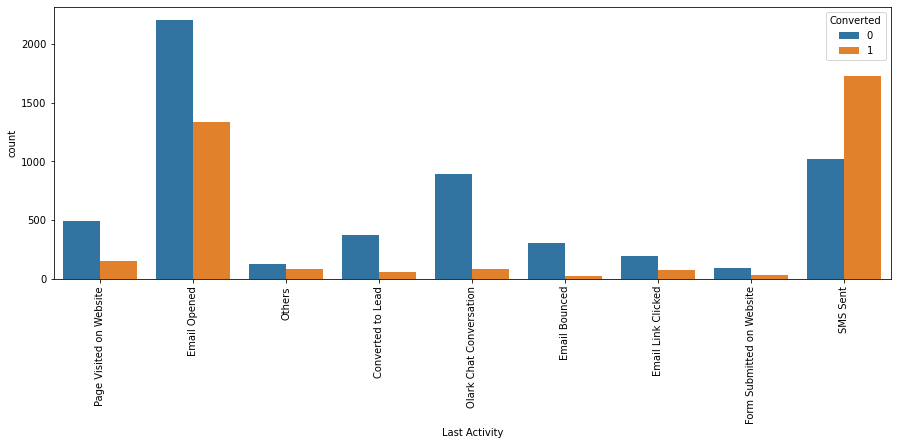

In [405]:
#visualizing count of Last Activity Variable 

plt.figure(figsize=(15,5))
s1=sns.countplot(x='Last Activity', hue='Converted' , data = leads_df)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

#### Lead Origin

In [406]:
#checking value counts of Lead Origin
leads_df['Lead Origin'].value_counts(dropna=False)

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

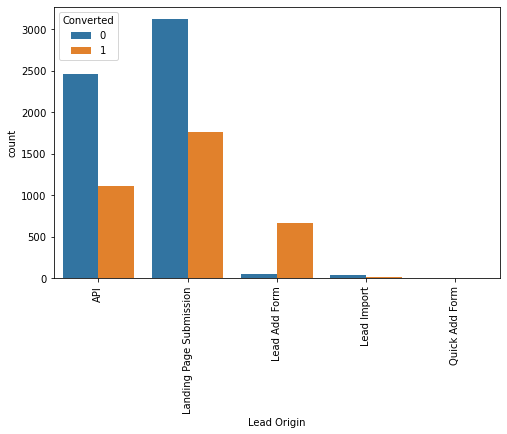

In [407]:
#visualizing count of Variable based on Converted value

plt.figure(figsize=(8,5))
s1=sns.countplot(leads_df['Lead Origin'], hue='Converted', data =leads_df)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

API and Landing Page Submission bring higher number of leads as well as conversion.

Lead Add Form has a very high conversion rate but count of leads are not very high.

Lead Import and Quick Add Form get very few leads.

In order to improve overall lead conversion rate, we have to improve lead converion of API and Landing Page Submission origin and generate more leads from Lead Add Form.

In [408]:
#checking percentage of null values in each column after second analysis

round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)

Lead Origin                                      0.00
Lead Source                                      0.00
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    0.00
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums                               0.00
Newspaper                                        0.00
Digital Advertisement       

#### Do not call and Do Not Email

In [409]:
#checking value counts for Do Not Call
leads_df['Do Not Call'].value_counts(dropna=False)

No     9238
Yes       2
Name: Do Not Call, dtype: int64

In [410]:
#checking value counts for Do Not Email
leads_df['Do Not Email'].value_counts(dropna=False)

No     8506
Yes     734
Name: Do Not Email, dtype: int64

We Can append the Do Not Call Column to the list of Columns to be Dropped since > 90% is of only one Value

In [411]:
# Append 'Do Not Call' to the cols_to_drop List
col_drop.append('Do Not Call')

#checking updated list for columns to be dropped
col_drop

['Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque',
 'Country',
 'What matters most to you in choosing a course',
 'Do Not Call']

#### Last Notable Activity

In [412]:
#checking value counts for variable

leads_df['Last Notable Activity'].value_counts()

Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Resubscribed to emails             1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Name: Last Notable Activity, dtype: int64

In [413]:
#clubbing lower frequency values

leads_df['Last Notable Activity'] = leads_df['Last Notable Activity'].replace(['Had a Phone Conversation',
                                                                       'Email Marked Spam',
                                                                         'Unreachable',
                                                                         'Unsubscribed',
                                                                         'Email Bounced',                                                                    
                                                                       'Resubscribed to emails',
                                                                       'View in browser link Clicked',
                                                                       'Approached upfront', 
                                                                       'Form Submitted on Website', 
                                                                       'Email Received'],'Other_Notable_activity')

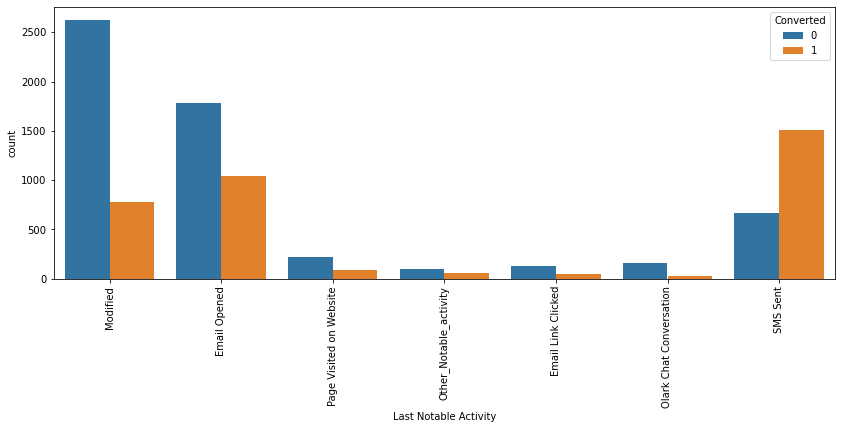

In [414]:
#visualizing count of Variable based on Converted value

plt.figure(figsize = (14,5))
ax1=sns.countplot(x = "Last Notable Activity", hue = "Converted", data = leads_df)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
plt.show()

Maximum leads are generated having last activity as Email opened but conversion rate is not too good.

SMS sent as last acitivity has high conversion rate.

In [415]:
# Append 'Last Notable Activity'to the cols_to_drop List as this is a sales team generated data
col_drop.append('Last Notable Activity')

In [416]:
# checking final list of columns to be dropped
col_drop

['Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque',
 'Country',
 'What matters most to you in choosing a course',
 'Do Not Call',
 'Last Notable Activity']

In [417]:
#dropping columns
leads_df = leads_df.drop(col_drop,1)

#checking info of dataset for remaining columns
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9240 non-null   object 
 1   Lead Source                             9240 non-null   object 
 2   Do Not Email                            9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9103 non-null   float64
 5   Total Time Spent on Website             9240 non-null   int64  
 6   Page Views Per Visit                    9103 non-null   float64
 7   Last Activity                           9240 non-null   object 
 8   Specialization                          9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  Tags                                    9240 non-null   obje

In [418]:
#checking dataset
leads_df.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,City,A free copy of Mastering The Interview
0,API,Olark Chat,No,0,0.0,0,0.0,Page Visited on Website,Not Specified,Unemployed,Interested in other courses,Mumbai,No
1,API,Organic Search,No,0,5.0,674,2.5,Email Opened,Not Specified,Unemployed,Ringing,Mumbai,No
2,Landing Page Submission,Direct Traffic,No,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,Mumbai,Yes
3,Landing Page Submission,Direct Traffic,No,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,Ringing,Mumbai,No
4,Landing Page Submission,Google,No,1,2.0,1428,1.0,Converted to Lead,Not Specified,Unemployed,Will revert after reading the email,Mumbai,No


## Numerical Attributes Analysis:

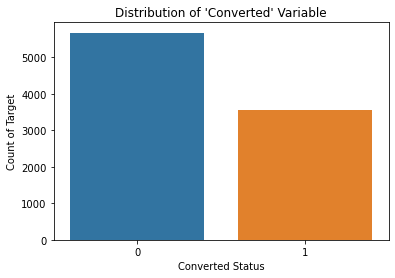

In [419]:
#Converted is the target variable, Indicates whether a lead has been successfully converted (1) or not (0).
#Visualizing Distribution of 'Converted' Variable
sns.countplot(leads_df.Converted)
plt.xlabel("Converted Status")
plt.ylabel("Count of Target")
plt.title("Distribution of 'Converted' Variable")
plt.show()

In [420]:
# Finding out conversion rate
Converted = (sum(leads_df['Converted'])/len(leads_df['Converted'].index))*100
Converted

38.53896103896104

Currently, the lead Conversion rate is 38% 

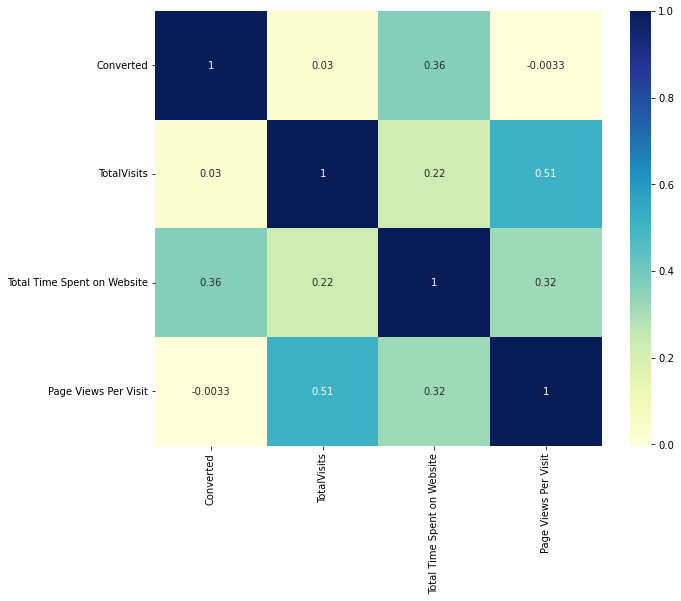

In [421]:
#Checking correlations of numeric values using heatmap

# Size of the figure
plt.figure(figsize=(10,8))

# heatmap
sns.heatmap(leads_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

#### Total Visits

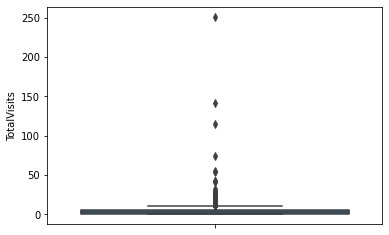

In [422]:
#visualizing spread of variable Total Visits

sns.boxplot(y=leads_df['TotalVisits'])
plt.show()

We can presence of outliers here

In [423]:
#checking percentile values for "Total Visits"

leads_df['TotalVisits'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
5%          0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

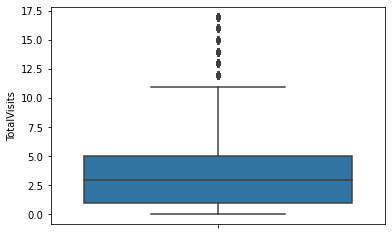

In [424]:
#Outlier Treatment: capping the outliers to 95% value for analysis

percentiles = leads_df['TotalVisits'].quantile([0.05,0.99]).values
leads_df['TotalVisits'][leads_df['TotalVisits'] <= percentiles[0]] = percentiles[0]
leads_df['TotalVisits'][leads_df['TotalVisits'] >= percentiles[1]] = percentiles[1]

#visualizing variable after outlier treatment
sns.boxplot(y=leads_df['TotalVisits'])
plt.show()

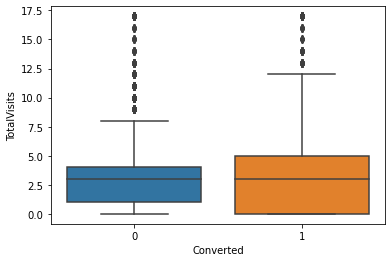

In [425]:
# Visualizing TotalVisits w.r.t Target Variable 'Converted'
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = leads_df)
plt.show()

As the median for both converted and non-converted leads are same , nothing coclusive can be said on the basis of variable TotalVisits

#### Total time spent on website

In [426]:
#checking percentiles for "Total Time Spent on Website"

leads_df['Total Time Spent on Website'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    9240.000000
mean      487.698268
std       548.021466
min         0.000000
5%          0.000000
25%        12.000000
50%       248.000000
75%       936.000000
90%      1380.000000
95%      1562.000000
99%      1840.610000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

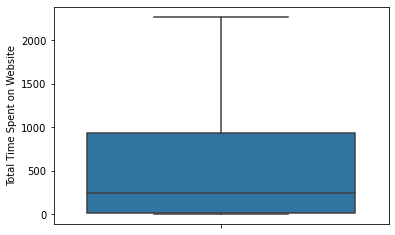

In [427]:
#visualizing spread of variable 'Total Time Spent on Website'
sns.boxplot(y = leads_df['Total Time Spent on Website'])
plt.show()

there are no major Outliers for the above variable

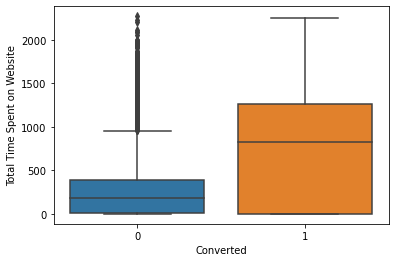

In [428]:
# Visualizing 'Total Time Spent on Website' w.r.t Target Variable 'converted'
sns.boxplot(y = 'Total Time Spent on Website', x = 'Converted', data = leads_df)
plt.show()

As can be seen, leads spending more time on website are more likely to convert , thus website should be made more enagaging to increase conversion rate

#### Page views per visit

In [429]:
#checking spread of "Page Views Per Visit"

leads_df['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

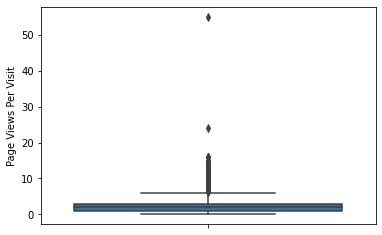

In [430]:
#visualizing spread of variable 'Page Views Per Visit'

plt.figure(figsize=(6,4))
sns.boxplot(y=leads_df['Page Views Per Visit'])
plt.show()

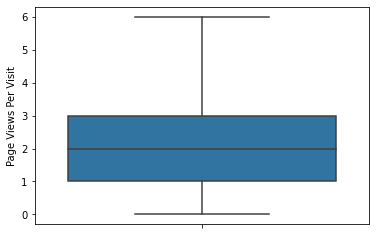

In [431]:
#Outlier Treatment: capping the outliers to 95% value for analysis
percentiles = leads_df['Page Views Per Visit'].quantile([0.05,0.95]).values
leads_df['Page Views Per Visit'][leads_df['Page Views Per Visit'] <= percentiles[0]] = percentiles[0]
leads_df['Page Views Per Visit'][leads_df['Page Views Per Visit'] >= percentiles[1]] = percentiles[1]

#visualizing variable after outlier treatment
sns.boxplot(y=leads_df['Page Views Per Visit'])
plt.show()

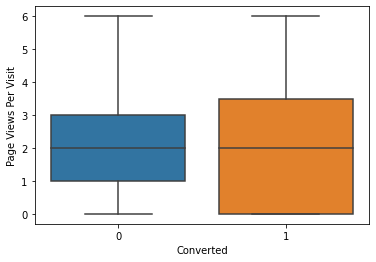

In [432]:
#visualizing 'Page Views Per Visit' w.r.t Target variable 'Converted'
sns.boxplot(y = 'Page Views Per Visit', x = 'Converted', data = leads_df)
plt.show()

Median for converted and not converted leads is almost same.
Nothing conclusive can be said on the basis of Page Views Per Visit.

In [433]:
#Drop all rows which have Nan Values. Since the number of Dropped rows is less than 2%, it will not affect the model
leads_df = leads_df.dropna()

In [434]:
#checking missing values in leftover columns

round(100*(leads_df.isnull().sum()/len(leads_df.index)),2)

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Last Activity                             0.0
Specialization                            0.0
What is your current occupation           0.0
Tags                                      0.0
City                                      0.0
A free copy of Mastering The Interview    0.0
dtype: float64

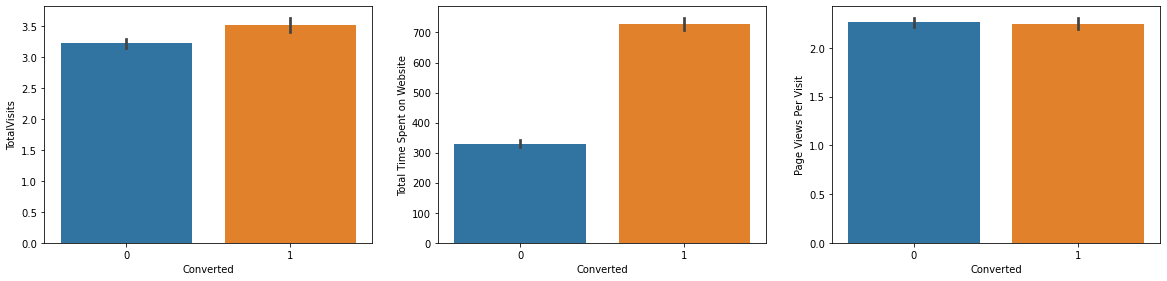

In [435]:
# Now check the conversions for all numeric values

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'TotalVisits', x='Converted', data = leads_df)
plt.subplot(4,3,2)
sns.barplot(y = 'Total Time Spent on Website', x='Converted', data = leads_df)
plt.subplot(4,3,3)
sns.barplot(y = 'Page Views Per Visit', x='Converted', data = leads_df)
plt.show()

The conversion rate is higher with all thess variables

# Data Preparation

## Converting Do not email to binay variable

In [436]:
# List of variables to map

varlist =  ['Do Not Email']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
leads_df[varlist] = leads_df[varlist].apply(binary_map)

In [437]:
leads_df.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,City,A free copy of Mastering The Interview
0,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Not Specified,Unemployed,Interested in other courses,Mumbai,No
1,API,Organic Search,0,0,5.0,674,2.5,Email Opened,Not Specified,Unemployed,Ringing,Mumbai,No
2,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,Mumbai,Yes
3,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,Ringing,Mumbai,No
4,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,Not Specified,Unemployed,Will revert after reading the email,Mumbai,No


In [438]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9103 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9103 non-null   object 
 1   Lead Source                             9103 non-null   object 
 2   Do Not Email                            9103 non-null   int64  
 3   Converted                               9103 non-null   int64  
 4   TotalVisits                             9103 non-null   float64
 5   Total Time Spent on Website             9103 non-null   int64  
 6   Page Views Per Visit                    9103 non-null   float64
 7   Last Activity                           9103 non-null   object 
 8   Specialization                          9103 non-null   object 
 9   What is your current occupation         9103 non-null   object 
 10  Tags                                    9103 non-null   obje

## Dummy Variable Creation

In [439]:
#list of categorical columns

categorical_col= leads_df.select_dtypes(include=['object']).columns
categorical_col

Index(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization',
       'What is your current occupation', 'Tags', 'City',
       'A free copy of Mastering The Interview'],
      dtype='object')

In [440]:
#getting dummies and dropping the first column and adding the results to the master dataframe
dummy = pd.get_dummies(leads_df[['Lead Origin']], drop_first=True)
leads_df = pd.concat([leads_df,dummy],1)

dummy = pd.get_dummies(leads_df['Specialization'], prefix  = 'Specialization')
dummy = dummy.drop(['Specialization_Not Specified'], 1)
leads = pd.concat([leads_df, dummy], axis = 1)

dummy = pd.get_dummies(leads_df['Lead Source'], prefix  = 'Lead Source')
dummy = dummy.drop(['Lead Source_Others'], 1)
leads_df = pd.concat([leads_df, dummy], axis = 1)

dummy = pd.get_dummies(leads_df['Last Activity'], prefix  = 'Last Activity')
dummy = dummy.drop(['Last Activity_Others'], 1)
leads = pd.concat([leads_df, dummy], axis = 1)

dummy = pd.get_dummies(leads_df['Tags'], prefix  = 'Tags')
dummy = dummy.drop(['Tags_Not Specified'], 1)
leads = pd.concat([leads_df, dummy], axis = 1)

dummy = pd.get_dummies(leads_df['What is your current occupation'], prefix  = 'What is your current occupation')
dummy = dummy.drop(['What is your current occupation_Unemployed'], 1)
leads_df = pd.concat([leads_df, dummy], axis = 1)

In [441]:
#dropping the original columns after dummy variable creation

leads_df.drop(categorical_col,1,inplace = True)

In [442]:
#checking dataset after dummy variable creation
leads_df.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_Welingak Website,What is your current occupation_Businessman,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,0,0,0.0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,5.0,674,2.5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,2.0,1532,2.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1.0,305,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,2.0,1428,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


# Train-Test Split

In [443]:
# Importing feature variable to X
X=leads_df.drop('Converted', axis=1)

X.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_Welingak Website,What is your current occupation_Businessman,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,0,0.0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,5.0,674,2.5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,2.0,1532,2.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1.0,305,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2.0,1428,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [444]:
# Putting response variable to y
y = leads_df['Converted']

#checking head of y
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [445]:
# Train - Test Split (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

# Feature Scaling

In [446]:
#scaling of features
scaler = StandardScaler()

num_cols=X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

#checking X-train dataset after scaling
X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_Welingak Website,What is your current occupation_Businessman,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
7248,-0.292437,-0.100097,0.029224,0.409287,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1542,-0.292437,0.209825,1.421604,0.966512,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
70,-0.292437,-0.719941,2.215696,-0.705163,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5914,-0.292437,-0.100097,0.698219,0.409287,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5038,-0.292437,2.069357,1.483246,0.130674,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


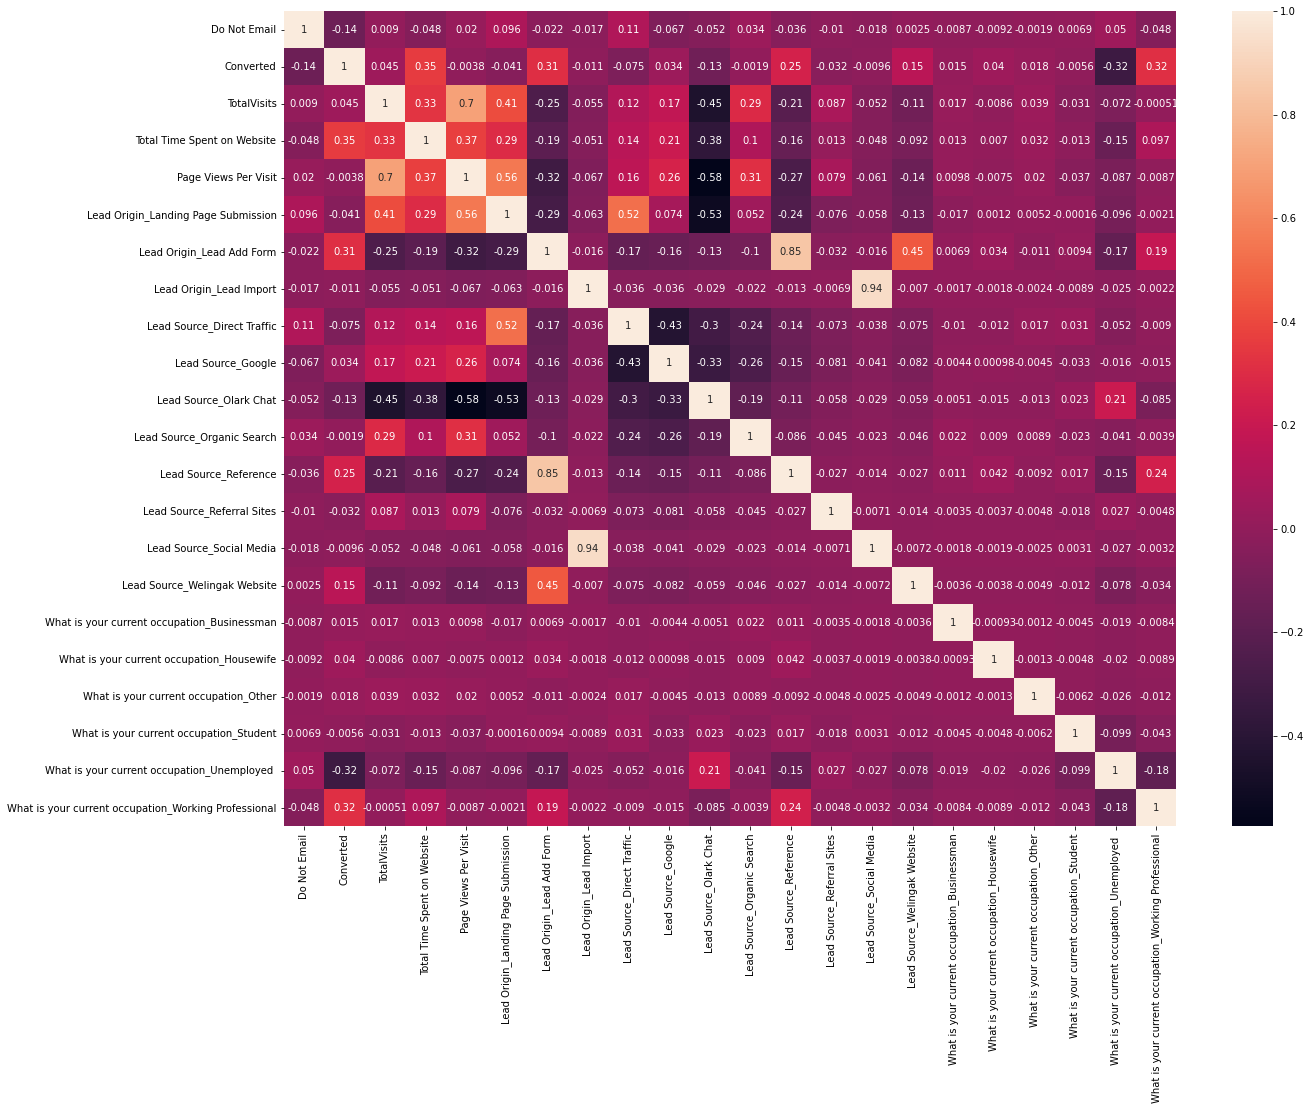

In [447]:
# Plotting correlation matrix
plt.figure(figsize = (20,15))
sns.heatmap(leads_df.corr(),annot = True)
plt.show()

Dropping highly correlated dummy variables which -0.53 between Lead Source_Olark Chat and Lead Origin_Landing Page Submission

## Dropping highly correlated dummy variables

In [279]:
X_test = X_test.drop(['Lead Source_Olark Chat','Lead Origin_Landing Page Submission'],1)

In [280]:
X_train = X_train.drop(['Lead Source_Olark Chat','Lead Origin_Landing Page Submission'],1)

# Model Building using Stats Model 

## RFE (Recursive Feature Elimination)

In [281]:
## Necessary libraries imported above.
##After imporing LogisticRegression from sklearn

log_reg = LogisticRegression() 


## After imporing REF from sklearn, running RFE with 15 variables

rfe = RFE(log_reg, 15)
rfe = rfe.fit(X_train, y_train)

In [282]:
rfe.support_

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True])

In [283]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('TotalVisits', False, 3),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 5),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', True, 1),
 ('Lead Source_Direct Traffic', True, 1),
 ('Lead Source_Google', True, 1),
 ('Lead Source_Organic Search', True, 1),
 ('Lead Source_Reference', True, 1),
 ('Lead Source_Referral Sites', True, 1),
 ('Lead Source_Social Media', False, 2),
 ('Lead Source_Welingak Website', True, 1),
 ('What is your current occupation_Businessman', False, 4),
 ('What is your current occupation_Housewife', True, 1),
 ('What is your current occupation_Other', True, 1),
 ('What is your current occupation_Student', True, 1),
 ('What is your current occupation_Unemployed ', True, 1),
 ('What is your current occupation_Working Professional', True, 1)]

In [284]:
#list of RFE supported columns
col = X_train.columns[rfe.support_]
col

Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import',
       'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Welingak Website',
       'What is your current occupation_Housewife',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed ',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [285]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit', 'Lead Source_Social Media',
       'What is your current occupation_Businessman'],
      dtype='object')

## Buliding Model

### Model 1

In [286]:
X_train_sm = sm.add_constant(X_train[col])
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6372
Model:                            GLM   Df Residuals:                     6356
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2847.2
Date:                Tue, 18 Oct 2022   Deviance:                       5694.4
Time:                        20:47:07   Pearson chi2:                 6.52e+03
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.1362      0.085      1.612      0.107      -0.029       0.302
Do Not Email                                            -0.3761      0.045     -8.410      0.000      -0.464      -0.288
Total Time Spent on Website                              1.0857      0.039     28.145      0.000       1.010       1.161
Lead Origin_Lead Add Form                                4.4777      0.768      5.830      0.000       2.972       5.983
Lead Origin_Lead Import                                 -0.4903      0.546     -0.899      0.369      -1.560       0.579
Lead Source_Direct Traffic                              -1.1288      0.108    -10.424      0.000      -1.341      -0.917
Lead Source_Google                                      -0.8435      0.104     -8.132      0.000      -1.047      -0.640
Lead Source_Organic Search                              -0.8636      0.124     -6.967      0.000      -1.107      -0.621
Lead Source_Reference                                   -1.5340      0.808     -1.898      0.058      -3.118       0.050
Lead Source_Referral Sites                              -1.2095      0.305     -3.960      0.000      -1.808      -0.611
Lead Source_Welingak Website                             0.2871      1.051      0.273      0.785      -1.773       2.347
What is your current occupation_Housewife               21.6483   1.23e+04      0.002      0.999    -2.4e+04     2.4e+04
What is your current occupation_Other                    0.5131      0.803      0.639      0.523      -1.061       2.087
What is your current occupation_Student                 -0.4913      0.217     -2.263      0.024      -0.917      -0.066
What is your current occupation_Unemployed              -1.3871      0.084    -16.544      0.000      -1.551      -1.223
What is your current occupation_Working Professional     2.5719      0.188     13.701      0.000       2.204       2.940
========================================================================================================================
"""

p-value of "What is your current occupation_Housewife" is high, dropping it.

In [287]:
col = col.drop('What is your current occupation_Housewife',1)

### Model 2

In [288]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6372
Model:                            GLM   Df Residuals:                     6357
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2850.0
Date:                Tue, 18 Oct 2022   Deviance:                       5700.0
Time:                        20:47:15   Pearson chi2:                 6.52e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.1362      0.084      1.612      0.107      -0.029       0.302
Do Not Email                                            -0.3767      0.045     -8.425      0.000      -0.464      -0.289
Total Time Spent on Website                              1.0848      0.039     28.143      0.000       1.009       1.160
Lead Origin_Lead Add Form                                4.4769      0.768      5.828      0.000       2.971       5.982
Lead Origin_Lead Import                                 -0.4911      0.546     -0.900      0.368      -1.560       0.578
Lead Source_Direct Traffic                              -1.1258      0.108    -10.402      0.000      -1.338      -0.914
Lead Source_Google                                      -0.8422      0.104     -8.121      0.000      -1.045      -0.639
Lead Source_Organic Search                              -0.8563      0.124     -6.917      0.000      -1.099      -0.614
Lead Source_Reference                                   -1.5279      0.808     -1.891      0.059      -3.112       0.056
Lead Source_Referral Sites                              -1.2089      0.305     -3.959      0.000      -1.807      -0.610
Lead Source_Welingak Website                             0.2877      1.051      0.274      0.784      -1.772       2.348
What is your current occupation_Other                    0.5112      0.803      0.637      0.524      -1.062       2.084
What is your current occupation_Student                 -0.4937      0.217     -2.274      0.023      -0.919      -0.068
What is your current occupation_Unemployed              -1.3890      0.084    -16.570      0.000      -1.553      -1.225
What is your current occupation_Working Professional     2.5692      0.188     13.688      0.000       2.201       2.937
========================================================================================================================
"""

p-value of variable "Lead Source_Welingak Website" is high, dropping it

In [289]:
col = col.drop('Lead Source_Welingak Website',1)

### Model 3

In [290]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6372
Model:                            GLM   Df Residuals:                     6358
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2850.0
Date:                Tue, 18 Oct 2022   Deviance:                       5700.1
Time:                        20:47:25   Pearson chi2:                 6.53e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.1379      0.084      1.637      0.102      -0.027       0.303
Do Not Email                                            -0.3774      0.045     -8.445      0.000      -0.465      -0.290
Total Time Spent on Website                              1.0853      0.039     28.180      0.000       1.010       1.161
Lead Origin_Lead Add Form                                4.6378      0.526      8.821      0.000       3.607       5.668
Lead Origin_Lead Import                                 -0.4924      0.546     -0.903      0.367      -1.562       0.577
Lead Source_Direct Traffic                              -1.1277      0.108    -10.440      0.000      -1.339      -0.916
Lead Source_Google                                      -0.8450      0.103     -8.186      0.000      -1.047      -0.643
Lead Source_Organic Search                              -0.8582      0.124     -6.943      0.000      -1.101      -0.616
Lead Source_Reference                                   -1.6901      0.577     -2.927      0.003      -2.822      -0.558
Lead Source_Referral Sites                              -1.2108      0.305     -3.966      0.000      -1.809      -0.612
What is your current occupation_Other                    0.5111      0.803      0.637      0.524      -1.062       2.084
What is your current occupation_Student                 -0.4940      0.217     -2.276      0.023      -0.920      -0.069
What is your current occupation_Unemployed              -1.3893      0.084    -16.574      0.000      -1.554      -1.225
What is your current occupation_Working Professional     2.5694      0.188     13.688      0.000       2.201       2.937
========================================================================================================================
"""

p-value of variable "What is your current occupation_Other" to be dropped

In [291]:
col = col.drop('What is your current occupation_Other',1)

### Model 4

In [292]:
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6372
Model:                            GLM   Df Residuals:                     6359
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2850.2
Date:                Tue, 18 Oct 2022   Deviance:                       5700.5
Time:                        20:47:35   Pearson chi2:                 6.53e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.1396      0.084      1.658      0.097      -0.025       0.305
Do Not Email                                            -0.3768      0.045     -8.441      0.000      -0.464      -0.289
Total Time Spent on Website                              1.0860      0.039     28.202      0.000       1.010       1.161
Lead Origin_Lead Add Form                                4.6361      0.526      8.819      0.000       3.606       5.667
Lead Origin_Lead Import                                 -0.4933      0.546     -0.904      0.366      -1.562       0.576
Lead Source_Direct Traffic                              -1.1280      0.108    -10.444      0.000      -1.340      -0.916
Lead Source_Google                                      -0.8457      0.103     -8.193      0.000      -1.048      -0.643
Lead Source_Organic Search                              -0.8589      0.124     -6.948      0.000      -1.101      -0.617
Lead Source_Reference                                   -1.6894      0.577     -2.926      0.003      -2.821      -0.558
Lead Source_Referral Sites                              -1.2123      0.305     -3.970      0.000      -1.811      -0.614
What is your current occupation_Student                 -0.4954      0.217     -2.282      0.023      -0.921      -0.070
What is your current occupation_Unemployed              -1.3907      0.084    -16.594      0.000      -1.555      -1.226
What is your current occupation_Working Professional     2.5683      0.188     13.683      0.000       2.200       2.936
========================================================================================================================
"""

p-value of variable "Lead Origin_Lead Import" is high, dropping i

In [293]:

col = col.drop('Lead Origin_Lead Import',1)

### Model 5

In [294]:
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6372
Model:                            GLM   Df Residuals:                     6360
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2850.7
Date:                Tue, 18 Oct 2022   Deviance:                       5701.4
Time:                        20:48:24   Pearson chi2:                 6.52e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.1293      0.084      1.548      0.122      -0.034       0.293
Do Not Email                                            -0.3764      0.045     -8.433      0.000      -0.464      -0.289
Total Time Spent on Website                              1.0862      0.038     28.214      0.000       1.011       1.162
Lead Origin_Lead Add Form                                4.6424      0.526      8.833      0.000       3.612       5.672
Lead Source_Direct Traffic                              -1.1184      0.108    -10.399      0.000      -1.329      -0.908
Lead Source_Google                                      -0.8363      0.103     -8.139      0.000      -1.038      -0.635
Lead Source_Organic Search                              -0.8494      0.123     -6.893      0.000      -1.091      -0.608
Lead Source_Reference                                   -1.6853      0.577     -2.919      0.004      -2.817      -0.554
Lead Source_Referral Sites                              -1.2027      0.305     -3.941      0.000      -1.801      -0.605
What is your current occupation_Student                 -0.4922      0.217     -2.267      0.023      -0.918      -0.067
What is your current occupation_Unemployed              -1.3872      0.084    -16.569      0.000      -1.551      -1.223
What is your current occupation_Working Professional     2.5681      0.188     13.682      0.000       2.200       2.936
========================================================================================================================
"""

p-value of variable "What is your current occupation_Student" is high, dropping it

In [295]:
col = col.drop('What is your current occupation_Student',1)

### Model 6

In [296]:
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6372
Model:                            GLM   Df Residuals:                     6361
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2853.4
Date:                Tue, 18 Oct 2022   Deviance:                       5706.7
Time:                        20:48:33   Pearson chi2:                 6.52e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.1074      0.083      1.295      0.195      -0.055       0.270
Do Not Email                                            -0.3761      0.045     -8.429      0.000      -0.463      -0.289
Total Time Spent on Website                              1.0850      0.038     28.216      0.000       1.010       1.160
Lead Origin_Lead Add Form                                4.6585      0.525      8.867      0.000       3.629       5.688
Lead Source_Direct Traffic                              -1.1159      0.107    -10.386      0.000      -1.326      -0.905
Lead Source_Google                                      -0.8256      0.103     -8.052      0.000      -1.027      -0.625
Lead Source_Organic Search                              -0.8418      0.123     -6.835      0.000      -1.083      -0.600
Lead Source_Reference                                   -1.7068      0.577     -2.958      0.003      -2.838      -0.576
Lead Source_Referral Sites                              -1.1841      0.305     -3.884      0.000      -1.782      -0.587
What is your current occupation_Unemployed              -1.3703      0.083    -16.431      0.000      -1.534      -1.207
What is your current occupation_Working Professional     2.5845      0.188     13.779      0.000       2.217       2.952
========================================================================================================================
"""

# Calculating VIF

In [297]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,Lead Source_Reference,3.56
2,Lead Origin_Lead Add Form,3.52
8,What is your current occupation_Unemployed,1.32
4,Lead Source_Google,1.22
1,Total Time Spent on Website,1.19
9,What is your current occupation_Working Profes...,1.18
3,Lead Source_Direct Traffic,1.15
5,Lead Source_Organic Search,1.07
0,Do Not Email,1.02
7,Lead Source_Referral Sites,1.01


### Model 6 is our Final model

P-values are below 0.05 - rejecting Null hypothesis

All VIF's are now below 5

# Predicting a Train model

In [298]:
# Getting the Predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

7248    0.123137
1542    0.971214
70      0.818394
5914    0.227764
5038    0.731266
6004    0.252166
8409    0.768982
7110    0.242122
5177    0.204776
3820    0.551138
dtype: float64

In [299]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.12313718, 0.97121407, 0.81839355, 0.22776386, 0.73126617,
       0.25216552, 0.76898213, 0.2421217 , 0.20477574, 0.5511377 ])

In [300]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID
0,0,0.123137,7248
1,1,0.971214,1542
2,0,0.818394,70
3,1,0.227764,5914
4,0,0.731266,5038


In [301]:
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted
0,0,0.123137,7248,0
1,1,0.971214,1542,1
2,0,0.818394,70,1
3,1,0.227764,5914,0
4,0,0.731266,5038,1


### Metrics -Accuracy, Sensitivity, Specificity, False Positive Rate, Postitive Predictive Value and Negative Predictive Value

In [302]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[3547  402]
 [ 879 1544]]


In [303]:
# Overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.7989642184557438


In [304]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [305]:
# Let's see the sensitivity of logistic regression model
TP / float(TP+FN)

0.6372265786215435

In [306]:
# Let us calculate specificity
TN / float(TN+FP)

0.898202076475057

In [307]:
# Calculate False Postive Rate - predicting conversion when customer does not have convert
print(FP/ float(TN+FP))

0.10179792352494302


In [308]:
# positive predictive value 
print (TP / float(TP+FP))

0.7934224049331963


In [309]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8014008133755084


# Finding Optimal Cutoff Point

In [310]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.123137,7248,0,1,1,0,0,0,0,0,0,0,0
1,1,0.971214,1542,1,1,1,1,1,1,1,1,1,1,1
2,0,0.818394,70,1,1,1,1,1,1,1,1,1,1,0
3,1,0.227764,5914,0,1,1,1,0,0,0,0,0,0,0
4,0,0.731266,5038,1,1,1,1,1,1,1,1,1,0,0


In [311]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.380257  1.000000  0.000000
0.1   0.1  0.524482  0.982253  0.243606
0.2   0.2  0.685970  0.909203  0.549000
0.3   0.3  0.766478  0.832026  0.726260
0.4   0.4  0.805085  0.698308  0.870600
0.5   0.5  0.798964  0.637227  0.898202
0.6   0.6  0.782015  0.561700  0.917194
0.7   0.7  0.762712  0.473380  0.940238
0.8   0.8  0.735405  0.356170  0.968093
0.9   0.9  0.712335  0.259596  0.990124


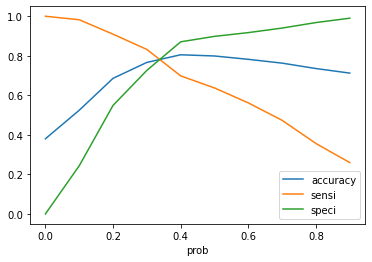

In [312]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

## From the curve above, 0.35 is the optimum point to take it as a cutoff probability.

In [313]:
y_train_pred_final['final_Predicted'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_Predicted
0,0,0.123137,7248,0,1,1,0,0,0,0,0,0,0,0,0
1,1,0.971214,1542,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.818394,70,1,1,1,1,1,1,1,1,1,1,0,1
3,1,0.227764,5914,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0.731266,5038,1,1,1,1,1,1,1,1,1,0,0,1


In [314]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.Converted_prob.map( lambda x: round(x*100))

y_train_pred_final[['Converted','Converted_prob','Prospect ID','final_Predicted','Lead_Score']].head()

,Converted,Converted_prob,Prospect ID,final_Predicted,Lead_Score
0,0,0.123137,7248,0,12
1,1,0.971214,1542,1,97
2,0,0.818394,70,1,82
3,1,0.227764,5914,0,23
4,0,0.731266,5038,1,73


In [315]:
# checking if 80% cases are correctly predicted based on the converted column.

# get the total of final predicted conversion / non conversion counts from the actual converted rates

checking_df = y_train_pred_final.loc[y_train_pred_final['Converted']==1,['Converted','final_Predicted']]
checking_df['final_Predicted'].value_counts()

1    2016
0     407
Name: final_Predicted, dtype: int64

In [316]:
# check the precentage of final_predicted conversions

2005/float(2005+414)

0.8288548987184787

#### we can see that the final prediction of conversions have a target of 82% conversion as per the X Educations CEO's requirement . Hence, we can say that this is a good model.

Overall Metrics - Accuracy, Confusion Metrics, Sensitivity, Specificity, False Postive Rate, Positive Predictive Value, Negative Predicitive Value on final prediction on train set
ted)


In [317]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

0.7664783427495292

In [318]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted )
confusion2

array([[2868, 1081],
       [ 407, 2016]], dtype=int64)

In [319]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [320]:
#sensitivity of our logistic regression model
TP / float(TP+FN)

0.8320264135369376

In [321]:
# Let us calculate specificity
TN / float(TN+FP)

0.7262598126107875

#### So as we can see above the model seems to be performing well. The ROC curve has a value of 0.86, which is very good. We have the following values for the Train Data:

Accuracy : 76%

Sensitivity :83%

Specificity : 72%

Some of the other Stats are derived below, indicating the False Positive Rate, Positive Predictive Value,Negative Predictive Values, Precision & Recall.

In [322]:
# Calculate False Postive Rate - predicting conversion when customer does not have convert
print(FP/ float(TN+FP))

0.27374018738921246


In [323]:
# Positive predictive value 
print (TP / float(TP+FP))

0.6509525347110107


In [324]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8757251908396947


### Precision and Recall

In [325]:
#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted )
confusion

array([[2868, 1081],
       [ 407, 2016]], dtype=int64)

In [326]:
## Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.6509525347110107

In [327]:
## Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.8320264135369376

In [328]:
precision_score(y_train_pred_final.Converted , y_train_pred_final.final_Predicted)

0.6509525347110107

In [329]:
recall_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

0.8320264135369376

# Predictions on the test set

In [330]:
#scaling test set

num_cols=X_test.select_dtypes(include=['float64', 'int64']).columns

X_test[num_cols] = scaler.transform(X_test[num_cols])

X_test.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_Welingak Website,What is your current occupation_Businessman,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
8075,3.419536,-1.029863,-0.884526,-1.262388,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1636,-0.292437,-1.029863,-0.884526,-1.262388,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7621,-0.292437,-1.029863,-0.884526,-1.262388,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2769,-0.292437,4.238811,1.280191,-0.532424,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1646,-0.292437,-0.410019,0.792495,-0.147938,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [331]:
X_test = X_test[col]
X_test.head()

,Do Not Email,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,What is your current occupation_Unemployed,What is your current occupation_Working Professional
8075,3.419536,-0.884526,1,0,0,0,1,0,0,1
1636,-0.292437,-0.884526,0,0,0,0,0,0,0,0
7621,-0.292437,-0.884526,0,0,0,0,0,0,1,0
2769,-0.292437,1.280191,0,1,0,0,0,0,0,0
1646,-0.292437,0.792495,0,0,1,0,0,0,0,0


In [332]:
X_test_sm = sm.add_constant(X_test)

In [333]:
X_test_sm.shape

(2731, 11)

In [334]:
y_test_pred = res.predict(X_test_sm)  

In [335]:
y_test_pred[:10]

8075    0.967641
1636    0.322494
7621    0.107875
2769    0.620223
1646    0.562571
513     0.901091
2370    0.046184
4822    0.883287
6731    0.151555
4814    0.282802
dtype: float64

In [336]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
8075,0.967641
1636,0.322494
7621,0.107875
2769,0.620223
1646,0.562571


In [337]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [338]:
# Putting CustID to index
y_test_df['Prospect ID'] = y_test_df.index

In [339]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [340]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [341]:
y_pred_final.head()

,Converted,Prospect ID,0
0,1,8075,0.967641
1,0,1636,0.322494
2,0,7621,0.107875
3,1,2769,0.620223
4,1,1646,0.562571


In [342]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_prob'})
y_pred_final.head()

,Converted,Prospect ID,Converted_prob
0,1,8075,0.967641
1,0,1636,0.322494
2,0,7621,0.107875
3,1,2769,0.620223
4,1,1646,0.562571


# Assigning Lead Score

In [343]:
# Rearranging the columns
y_pred_final = y_pred_final[['Prospect ID','Converted','Converted_prob']]
y_pred_final['Lead_Score'] = y_pred_final.Converted_prob.map( lambda x: round(x*100))

In [344]:
y_pred_final.head()

,Prospect ID,Converted,Converted_prob,Lead_Score
0,8075,1,0.967641,97
1,1636,0,0.322494,32
2,7621,0,0.107875,11
3,2769,1,0.620223,62
4,1646,1,0.562571,56


In [345]:
y_pred_final['final_Predicted'] = y_pred_final.Converted_prob.map(lambda x: 1 if x > 0.3 else 0)

In [346]:
y_pred_final.head()

,Prospect ID,Converted,Converted_prob,Lead_Score,final_Predicted
0,8075,1,0.967641,97,1
1,1636,0,0.322494,32,1
2,7621,0,0.107875,11,0
3,2769,1,0.620223,62,1
4,1646,1,0.562571,56,1


In [347]:
# checking if 80% cases are correctly predicted based on the converted column.

# get the total of final predicted conversion or non conversion counts from the actual converted rates

checking_test_df = y_pred_final.loc[y_pred_final['Converted']==1,['Converted','final_Predicted']]
checking_test_df['final_Predicted'].value_counts()

1    851
0    187
Name: final_Predicted, dtype: int64

In [348]:
# check the precentage of final_predicted conversions on test data

865/float(865+177)

0.8301343570057581

#### We can see that the final prediction of conversions have a target rate of 83% (same as predictions made on training data set)

### Overall Metrics - Accuracy, Confusion Metrics, Sensitivity, Specificity, False Postive Rate, Positive Predictive Value, Negative Predicitive Value on final prediction on test set

In [349]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_Predicted)

0.7704137678506042

In [350]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_Predicted )
confusion2

array([[1253,  440],
       [ 187,  851]], dtype=int64)

In [351]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [352]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8198458574181118

In [353]:
# Let us calculate specificity
TN / float(TN+FP)

0.7401063201417601

## Precision and Recall metrics for the test set

In [354]:
precision_score(y_pred_final.Converted , y_pred_final.final_Predicted)

0.6591789310611929

In [355]:
recall_score(y_pred_final.Converted, y_pred_final.final_Predicted)

0.8198458574181118

#### After running the model on the Test Data these are the figures we obtain:

Accuracy : 77%

Sensitivity :81%

Specificity :74%

In [356]:
print(res.params)

const                                                   0.107388
Do Not Email                                           -0.376057
Total Time Spent on Website                             1.084983
Lead Origin_Lead Add Form                               4.658491
Lead Source_Direct Traffic                             -1.115853
Lead Source_Google                                     -0.825602
Lead Source_Organic Search                             -0.841824
Lead Source_Reference                                  -1.706752
Lead Source_Referral Sites                             -1.184126
What is your current occupation_Unemployed             -1.370296
What is your current occupation_Working Professional    2.584484
dtype: float64


# Conclusion

While we have checked both Sensitivity-Specificity as well as Precision and Recall Metrics, we have considered the optimal cut off based on Sensitivity and Specificity for calculating the final prediction.

Accuracy, Sensitivity and Specificity values of test set are around 77%, 81% and 74% which are approximately closer to the respective values calculated using trained set.

Also the lead score calculated in the trained set of data shows the conversion rate on the final predicted model is around 80%

Hence overall this model seems to be good.


# Recommendation

#### Important features responsible for good conversion rate or the ones' which contributes more towards the probability of a lead getting converted are :

Total Time Spent on Website

Lead Origin_Lead Add Form

What is your current occupation_Working Professional